# Prédiction du prix de locations d'appartements sur Airbnb

Projet fin d'études effectué au sein de la Faculté de Sciences et Techniques Mohammedia (FSTM) par EL BELGHITI Hamza pour l'obtention de la licence en Mathématiques Appliquées.

### I. Introduction

Airbnb est une plateforme de marché Internet pour les locations de maisons et d’appartements à court terme. La plateforme permet à un utilisateur, par exemple, de louer son appartement pour une semaine pendant son absence, ou de louer sa chambre d’amis à des voyageurs. La société elle-même a connu une croissance rapide depuis sa création en 2008, jusqu'à une valorisation de plus de 70 milliards de dollars américains en 2022.

L’un des défis auxquels les hôtes Airbnb sont confrontés est de déterminer le prix de
location optimal par nuit. Les locataires potentiels peuvent filtrer les appartements selon des
critères tels que le prix, le nombre de chambres, le type de chambre, etc. Etant donné que 
Airbnb est une place de marché, le montant qu’un hôte peut facturer par nuit est étroitement
lié à la dynamique de la place de marché

### II. Importation de la base de données

##### Imporation des packages

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.spatial import distance
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

color = sns.color_palette()
sns.set_style('darkgrid')

In [3]:
dc_listings = pd.read_csv('dc_airbnb.csv')  
                                             
print(dc_listings.shape)
dc_listings.head()

(3723, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,7087327,https://www.airbnb.com/rooms/7087327,20151002231825,2015-10-03,Historic DC Condo-Walk to Capitol!,Professional pictures coming soon! Welcome to ...,NaN,Professional pictures coming soon! Welcome to ...,none,NaN,...,NaN,f,NaN,"DISTRICT OF COLUMBIA, WASHINGTON",f,flexible,f,f,18,NaN
1,975833,https://www.airbnb.com/rooms/975833,20151002231825,2015-10-03,Spacious Capitol Hill Townhouse,NaN,Beautifully renovated Capitol Hill townhouse. ...,Beautifully renovated Capitol Hill townhouse. ...,none,NaN,...,9.0,f,NaN,"DISTRICT OF COLUMBIA, WASHINGTON",f,strict,f,f,1,2.11
2,8249488,https://www.airbnb.com/rooms/8249488,20151002231825,2015-10-03,Spacious/private room for single,This is an ideal room for a single traveler th...,NaN,This is an ideal room for a single traveler th...,none,NaN,...,NaN,f,NaN,NaN,f,flexible,f,f,1,1.00
3,8409022,https://www.airbnb.com/rooms/8409022,20151002231825,2015-10-03,A wonderful bedroom with library,Prime location right on the Potomac River in W...,NaN,Prime location right on the Potomac River in W...,none,NaN,...,NaN,f,NaN,"DISTRICT OF COLUMBIA, WASHINGTON",f,flexible,f,f,1,NaN
4,8411173,https://www.airbnb.com/rooms/8411173,20151002231825,2015-10-03,Downtown Silver Spring,"Hi travellers! I live in this peaceful spot, b...",This is a 750 sq ft 1 bedroom 1 bathroom. Whi...,"Hi travellers! I live in this peaceful spot, b...",none,Silver Spring is booming. You can walk to a n...,...,NaN,f,NaN,NaN,f,flexible,f,f,1,NaN


### III. Exploration de l'ensemble de donnée

In [4]:
dc_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3723 entries, 0 to 3722
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3723 non-null   int64  
 1   listing_url                       3723 non-null   object 
 2   scrape_id                         3723 non-null   int64  
 3   last_scraped                      3723 non-null   object 
 4   name                              3723 non-null   object 
 5   summary                           3457 non-null   object 
 6   space                             2977 non-null   object 
 7   description                       3722 non-null   object 
 8   experiences_offered               3723 non-null   object 
 9   neighborhood_overview             2469 non-null   object 
 10  notes                             1712 non-null   object 
 11  transit                           2588 non-null   object 
 12  thumbn

Notre ensemble de données contient 3723 lignes (observations) avec 92 colonnes (caracteristiques). Pour notre cas, nous nous intéresserons seulement aux colonnes les plus importantes, car ce sont toutes les caracteristiques qu’un locataire pourrait utiliser pour evaluer quelle annonce choisir, selon ses besoins :

In [5]:
features = ["accommodates","bedrooms","bathrooms","beds","minimum_nights","maximum_nights","number_of_reviews","price"]
dc_listings = dc_listings[features]
dc_listings.head()

,accommodates,bedrooms,bathrooms,beds,minimum_nights,maximum_nights,number_of_reviews,price
0,4,1.0,1.0,2.0,1,1125,0,$160.00
1,6,3.0,3.0,3.0,2,30,65,$350.00
2,1,1.0,2.0,1.0,2,1125,1,$50.00
3,2,1.0,1.0,1.0,1,1125,0,$95.00
4,4,1.0,1.0,1.0,7,1125,0,$50.00


Suppression des caractères parasites comme le $, la virgule etc...

In [6]:
dc_listings['price'] = dc_listings.price.str.replace("\$|,",'').astype(float)

C:\Users\hamza\AppData\Local\Temp\ipykernel_5572\929158914.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  dc_listings['price'] = dc_listings.price.str.replace("\$|,",'').astype(float)


##### Visualisation des données

c:\Users\hamza\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

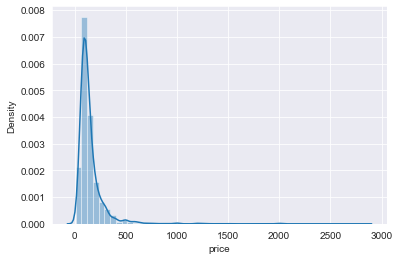

In [7]:
sns.distplot(dc_listings['price'])

<AxesSubplot:xlabel='accommodates', ylabel='price'>

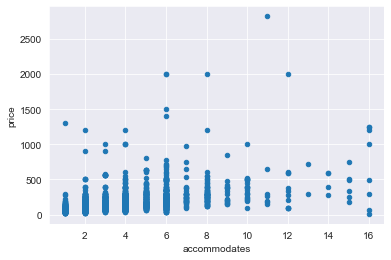

In [8]:
var = 'accommodates'
data = pd.concat([dc_listings['price'], dc_listings[var]], axis=1)
data.plot.scatter(x=var, y='price')

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

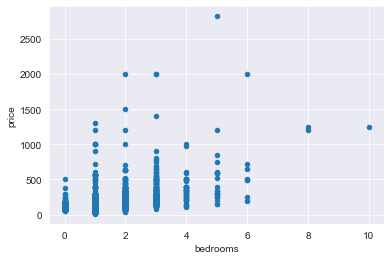

In [10]:
var = 'bedrooms'
data = pd.concat([dc_listings['price'], dc_listings[var]], axis=1)
data.plot.scatter(x=var, y='price')

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

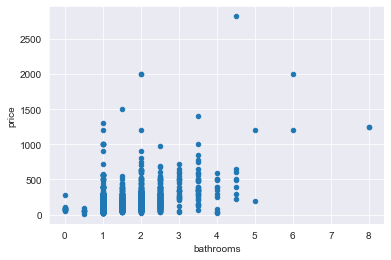

In [11]:
var = 'bathrooms'
data = pd.concat([dc_listings['price'], dc_listings[var]], axis=1)
data.plot.scatter(x=var, y='price')

<AxesSubplot:xlabel='beds', ylabel='price'>

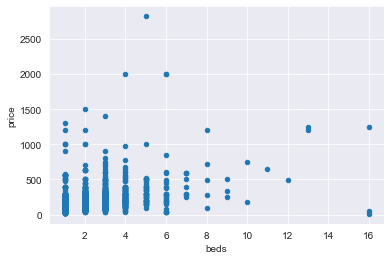

In [9]:
var = 'beds'
data = pd.concat([dc_listings['price'], dc_listings[var]], axis=1)
data.plot.scatter(x=var, y='price')

Valeurs manquantes

In [12]:
dc_listings.isna().sum()                        

accommodates          0
bedrooms             21
bathrooms            27
beds                 11
minimum_nights        0
maximum_nights        0
number_of_reviews     0
price                 0
dtype: int64

Etant donné que le nombre de lignes contenant une ou plusieurs valeurs manquantes  pour ces 3 colonnes est faible, nous pouvons sélectionner et supprimer ces lignes sans perdre  beaucoup d’informations  

In [13]:
dc_listings.dropna(subset=['bedrooms','bathrooms','beds'], axis=0, how='any', inplace=True )

### Matrice de correlation

<AxesSubplot:>

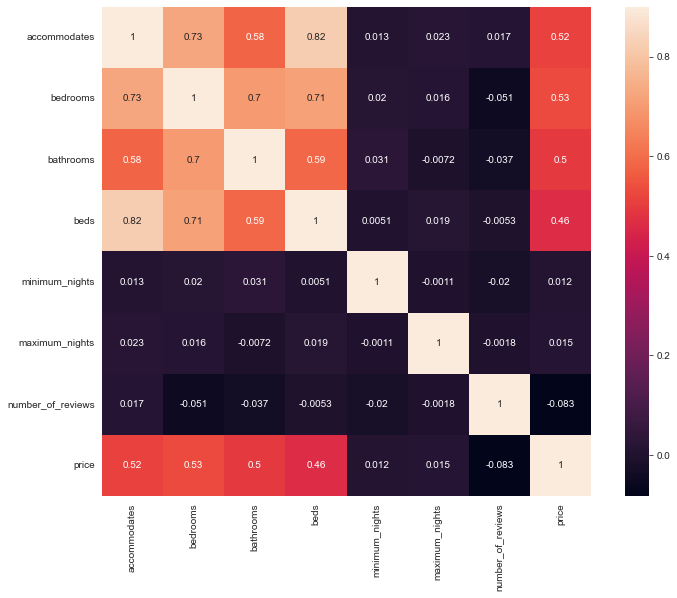

In [14]:
corrmat = dc_listings.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, annot=True, square=True)

On peut observer que les colonnes accommodates, bedrooms, bathrooms et beds sont les plus corrélées avec le prix. Cependant beds et accommodates sont aussi étroitement corrélés.

## IV. Creation et évaluation du modèle

Nous implémenterons l’algorithme des K plus proches voisins et l’utiliserons pour suggérer
un prix pour une nouvelle annonce sur la plateforme. Pour cette première partie du projet,
nous allons utiliser une valeur K fixe de 5, après on utilisera un algorithme K-NN depuis la 
librairie Scikit-Learn.

Supposons que l’appartement que nous souhaitons louer peut accueillir trois personnes, trouvons la valeur absolue de la difference entre l’observation et le point de donnees que nous voulons prédire pour la caractéristique que nous utilisons (accommodates)

In [15]:
our_acc_value = 3
first_living_space_value = dc_listings.loc[0,'accommodates']
first_distance = np.abs(first_living_space_value - our_acc_value)
print(first_distance)

1


In [16]:
dc_listings['distance'] = np.abs(dc_listings.accommodates - our_acc_value)
dc_listings.distance.value_counts().sort_index()

0      457
1     2258
2      497
3      276
4       35
5       73
6       17
7       22
8        7
9        9
10       2
11       4
12       6
13       8
Name: distance, dtype: int64

On observe qu’il existe 457 annonces qui ont une distance de 0, et accueillent donc le
meme nombre de personnes que notre appartement. Ces annonces pourraient êetre un bon
point de depart.

In [17]:
dc_listings = dc_listings.sample(frac=1,random_state=0)
dc_listings = dc_listings.sort_values('distance')
dc_listings.price.head()

2541     50.0
690     125.0
3437    159.0
1259    101.0
2559    122.0
Name: price, dtype: float64

In [18]:
mean_price = dc_listings.price.iloc[:5].mean()
print(mean_price)

111.4


Nous avons maintenant fait notre première prédiction, notre modèle KNN nous a dit que 
lorsque nous n’utilisons que la colonne accommodates pour trouver un prix approprié pour 
notre annonce pour trois personnes, nous devrions louer notre appartement pour 111 $

## V. Evaluation du modèle

Division l’ensemble de donnees en 2 partitions : un esemble d'entraînement (75%) et un ensemble de test (25%)

In [19]:
dc_listings.drop('distance',axis=1)

train_df = dc_listings.copy().iloc[:2792]  # 75%    
test_df = dc_listings.copy().iloc[2792:]   # 25%        

Construction de la fonction KNN qui predit un prix moyen d’une nouvelle observation.

In [20]:
def predict_price(new_listing_value, feature_column):
    temp_df = train_df
    temp_df['distance'] = np.abs(dc_listings[feature_column] - new_listing_value)
    temp_df = temp_df.sort_values('distance')
    knn_5 = temp_df.price.iloc[:5]
    predicted_price = knn_5.mean()
    
    return(predicted_price)

Prediction des prix grâce à la fonction predict_price

In [21]:
test_df['predicted_price'] = test_df.accommodates.apply(predict_price, feature_column='accommodates')

Calculons la valeur RMSE pour les prédictions que nous avons faites sur 
l’ensemble de test 

In [23]:
test_df['squared_error'] = (test_df['predicted_price'] - test_df['price'])**(2)

print("RMSE : %.2f" % mean_squared_error(test_df['price'], test_df['predicted_price'], squared=False))
print("MAE : %.2f" % mean_absolute_error(test_df['price'], test_df['predicted_price']))

RMSE : 205.85
MAE : 109.57


Créons d’autres modèle qui utilisent différentes colonnes/caractéristiques
et regardons comment notre erreur varie :

In [24]:
for feature in ['accommodates','bedrooms','bathrooms','number_of_reviews']:
    test_df['predicted_price'] = test_df.accommodates.apply(predict_price,feature_column=feature)
    test_df['squared_error'] = (test_df['predicted_price'] - test_df['price'])**(2)
    mse = test_df['squared_error'].mean()
    rmse = mse ** (1/2)
    
    print("RMSE for the {} column: {}".format(feature, rmse))

RMSE for the accommodates column: 205.84578032771483
RMSE for the bedrooms column: 210.43352704839972
RMSE for the bathrooms column: 216.97133472192243
RMSE for the number_of_reviews column: 244.1999279763679


Nous pouvons constater que le meilleur modele des quatre que nous avons formés est 
celui utilisant la colonne/caractéristique accommodates. Cependant, les taux d’erreur que
nous obtenons sont assez elevés par rapport à la fourchette de prix des annonces dans 
notre ensemble de données.

# Normalisation de l'ensemble de données

Pour eviter qu’une seule colonne ait un impact trop important sur la distance, 
nous pouvons normaliser toutes les colonnes pour avoir une moyenne de 0 et un ecart type 
de 1.

In [25]:
normalized_listings = (dc_listings - dc_listings.mean()) / (dc_listings.std())
normalized_listings['price'] = dc_listings['price']
normalized_listings.head()

,accommodates,bedrooms,bathrooms,beds,minimum_nights,maximum_nights,number_of_reviews,price,distance
2541,-0.097589,-0.249467,-0.439151,-0.546858,-0.341375,-0.016573,-0.482505,50.0,-0.996634
690,-0.097589,-0.249467,-0.439151,-0.546858,-0.065038,-0.016573,-0.482505,125.0,-0.996634
3437,-0.097589,0.939875,1.264998,0.297345,0.763971,-0.016573,-0.448301,159.0,-0.996634
1259,-0.097589,-1.438810,-0.439151,-0.546858,-0.065038,-0.016573,-0.516709,101.0,-0.996634
2559,-0.097589,-0.249467,-0.439151,-0.546858,-0.065038,-0.016594,1.843350,122.0,-0.996634


In [26]:
normalized_listings.shape

(3671, 9)

Division de l’ensemble de donnees en deux sous ensembles, un pour l’entraînement et un pour le test.

In [28]:
normalized_listings = normalized_listings.sample(frac=1,random_state=0)

norm_train_df = normalized_listings.copy().iloc[0:2753] # 75%
norm_test_df = normalized_listings.copy().iloc[2753:] # 25 %

Utilisons la fonction euclidienne() pour calculer la distance euclidienne entre la première
et la cinquième ligne de notre ensemble de données :

In [29]:
first_listing = normalized_listings.iloc[0][['accommodates', 'bathrooms']]
fifth_listing = normalized_listings.iloc[4][['accommodates', 'bathrooms']]
first_fifth_distance = distance.euclidean(first_listing, fifth_listing)

print(first_fifth_distance)

2.7441032572768944


Créons une fonction K-NN de prédiction d’un modèle multivarié

In [30]:
def predict_price_multivariate(new_listing_value, feature_columns):
    temp_df = norm_train_df
    temp_df['distance'] = distance.cdist(temp_df[feature_columns],[new_listing_value[feature_columns]])
    temp_df = temp_df.sort_values('distance')
    knn_5 = temp_df.price.iloc[:5]
    predicted_price = knn_5.mean()
    
    return(predicted_price)
    
cols = ['accommodates', 'bathrooms']

norm_test_df['predicted_price'] = norm_test_df[cols].apply(predict_price_multivariate,feature_columns=cols,axis=1)
norm_test_df['squared_error'] = (norm_test_df['predicted_price'] - norm_test_df['price'])**(2)
mse = norm_test_df['squared_error'].mean()
rmse = mse ** (1/2)

print("%.2f" % rmse)

142.50


Une façon de mieux comprendre si une certaine valeur RMSE est ”bonne” est
de la normaliser a l’aide de la formule suivante : RMSEn = RMSE/(Ymax − Ymin)

In [32]:
normRMSE = rmse / (2822 - 10)

print("%.3f" % normRMSE)

0.051


#### VI. Modèle KNN de Scikit-learn

In [33]:
knn = KNeighborsRegressor(algorithm='brute', n_neighbors=7)

In [34]:
knn.fit(norm_train_df[cols], norm_train_df['price'])
two_features_predictions = knn.predict(norm_test_df[cols])

In [33]:
two_features_mse = mean_squared_error(norm_test_df['price'], two_features_predictions)
two_features_rmse = two_features_mse ** (1/2)
print("%.2f" % two_features_rmse)

128.07


Nous observons que notre RMSE est un peu différent de notre algorithme implémenté manuellement, cela est probablement dû à la fois aux différences de randomisation et a de légères différences d’implémentation entre notre algorithme KNN ”manuel” et la version scikit-learn.

In [35]:
knn = KNeighborsRegressor(algorithm='brute')

cols = ["accommodates","bathrooms", "beds", "bedrooms"]

knn.fit(norm_train_df[cols], norm_train_df['price'])
four_features_predictions = knn.predict(norm_test_df[cols])
four_features_mse = mean_squared_error(norm_test_df['price'], four_features_predictions)
four_features_rmse = four_features_mse ** (1/2)

print("%.2f" % four_features_rmse)

137.24


L’ajout de caractéristiques supplémentaires ne produit pas nécessairement un modèle plus précis.  Pour notre cas, l’utilisation de quatres caractéristiques ne fait pas de mal, mais imaginons le cas des entreprises comme Facebook ou Amazon qui ont des ensembles de données avec un nombre gigantesque de caractéristiques, il est impossible de tous les utiliser, c’est pourquoi il faut soigneusement choisir les caractéristiques les plus significatives.

In [36]:
normRMSE = four_features_rmse / (dc_listings['price'].max() - dc_listings['price'].min())
print("%.3f" % normRMSE)

0.049


Il serait préférable que le modèle principal à retenir comme solution à notre problème est le modèle qui utilisent les deux caractéristiques : accommodates et bathrooms, puisque la distance moyenne entre les prix prédits et les prix réels est la plus faible parmi tous les  modeles precedents, et il est le plus économique en terme de calcul et de temps.

## Conclusion

En guise de conclusion, le modèle que nous avons créé peut être potentiellement intégrée dans la partie backend de la plateforme Airbnb, ou il génère automatiquement des recommandations de prix de location du logement dès que l’annonceur fait entrer les caractéristiques de ce dernier, chose qui offrira une agréable expérience à l'utilisateur puisqu'il lui économisera du temps et d’efforts.